In [1]:
from fromscratchtoml.neural_network.models import Sequential
from fromscratchtoml.neural_network.optimizers import StochasticGradientDescent
from fromscratchtoml.neural_network.layers import Dense, Activation

import numpy as np
from sklearn.model_selection import train_test_split

from fromscratchtoml.toolbox.random import Distribution
from fromscratchtoml.toolbox.preprocess import to_onehot

In [2]:
from sklearn import datasets
from sklearn.utils import shuffle

from fromscratchtoml.toolbox import binary_visualize

%matplotlib inline

# Neural Networks

## Fitting a XOR gate

In [3]:
model1 = Sequential()
model1.add(Dense(5, input_dim=2, seed=1))
model1.add(Activation('sigmoid'))
model1.add(Dense(5, seed=2))
model1.add(Activation('sigmoid'))
model1.add(Dense(2, seed=3))
sgd = StochasticGradientDescent(learning_rate=0.1)
model1.compile(optimizer=sgd, loss="mean_squared_error")

In [4]:
X1 = np.array([[0, 0],[0, 1],[1, 0], [1, 1]])
y1 = np.array([[1,0], [0,1], [0,1], [1,0]])
y1

array([[1, 0],
       [0, 1],
       [0, 1],
       [1, 0]])

In [5]:
%time model1.fit(X1, y1, batch_size=4, epochs=200)

[███████████████████████████████████████ ] 99% 
epoch: 200/200  acc: 100.00  loss: 0.159 
[████████████████████████████████████████] 100% CPU times: user 163 ms, sys: 14.9 ms, total: 178 ms
Wall time: 147 ms


In [6]:
model1.layers[-1].biases

array([[1.07845107, 2.30950559]])

In [7]:
model1.layers[-1].weights

array([[-1.50910461, -0.01528225],
       [-0.14596701, -2.53637055],
       [-1.27728675,  0.08821369],
       [ 1.23492717, -0.08423619],
       [-1.7046021 ,  1.00555922]])

In [8]:
model1.predict(X1)

array([0, 1, 1, 0])

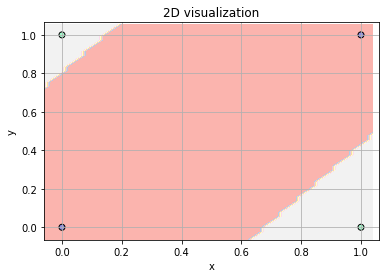

In [9]:
binary_visualize(X1, clf=model1, draw_contour=True)

## MNIST Digit Classification

In [10]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home=".")
print(len(mnist.data))
X2 = mnist.data/256.
y2 = to_onehot(mnist.target)

70000


In [11]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=60000, random_state=42)
X_train2.shape, y_train2.shape

((10000, 784), (10000, 10))

In [12]:
model2 = Sequential(verbose=True)
model2.add(Dense(30, input_dim=784, seed=10))
model2.add(Activation('sigmoid'))
model2.add(Dense(10, seed=10))
model2.add(Activation('sigmoid'))
sgd = StochasticGradientDescent(learning_rate=1)
model2.compile(optimizer=sgd, loss="mean_squared_error")

In [13]:
%time model2.fit(X_train2, y_train2, batch_size=8, epochs=5)


epoch: 1/5  acc: 89.18  loss: 0.031 
[████████                                ] 20% 
epoch: 2/5  acc: 94.65  loss: 0.018 
[████████████████                        ] 40% 
epoch: 3/5  acc: 95.45  loss: 0.015 
[████████████████████████                ] 60% 
epoch: 4/5  acc: 95.81  loss: 0.014 
[████████████████████████████████        ] 80% 
epoch: 5/5  acc: 96.54  loss: 0.012 
[████████████████████████████████████████] 100% CPU times: user 10.7 s, sys: 286 ms, total: 11 s
Wall time: 11 s


In [14]:
model2.predict(X_train2[12:17]), np.argmax(y_train2[12:17], axis=1)

(array([3, 9, 7, 1, 8]), array([3, 9, 7, 1, 8]))

In [15]:
model2.accuracy(X_test2, y_test2)

95.56333333333333

## Training a single perceptron

In [16]:
model3 = Sequential()
model3.add(Dense(1, input_dim=1, seed=10))
model3.add(Activation('sigmoid'))
sgd = StochasticGradientDescent(learning_rate=0.5)
model3.compile(optimizer=sgd, loss="mean_squared_error")

In [17]:
X3 = np.array([1])
y3 = np.array([0.2])

In [18]:
%time model3.fit(X3, y3, epochs=200)

[███████████████████████████████████████ ] 99% 
epoch: 200/200  acc: 50.00  loss: 0.000 
[████████████████████████████████████████] 100% CPU times: user 108 ms, sys: 12 ms, total: 120 ms
Wall time: 99.1 ms


In [19]:
model3.forwardpass(X3)

array([[0.20095324]])

## Iris Dataset

In [20]:
iris = datasets.load_iris()

X4 = iris.data[:, :2]
Y4 = to_onehot(iris.target[:])
X4, Y4 = shuffle(X4, Y4, random_state=10)

Xtrain4 = X4[:120]
Ytrain4 = Y4[:120]
Xtest4 = X4[120:]
Ytest4 = Y4[120:]

In [21]:
model4 = Sequential()
model4.add(Dense(5, input_dim=2, seed=1))
model4.add(Activation('sigmoid'))
model4.add(Dense(3, seed=2))
model4.add(Activation('sigmoid'))
sgd = StochasticGradientDescent(learning_rate=0.1)
model4.compile(optimizer=sgd, loss="mean_squared_error")

In [22]:
%time model4.fit(Xtrain4, Ytrain4, batch_size=32, epochs=100)

[███████████████████████████████████████ ] 99% 
epoch: 100/100  acc: 86.25  loss: 0.115 
[████████████████████████████████████████] 100% CPU times: user 168 ms, sys: 25.7 ms, total: 194 ms
Wall time: 167 ms


In [23]:
model4.predict(Xtrain4[:5]), Ytest4[:5]

(array([2, 2, 0, 2, 0]), array([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.]], dtype=float128))

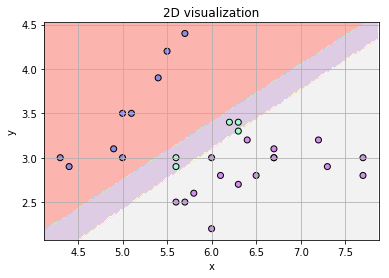

In [24]:
binary_visualize(Xtest4, clf=model4, draw_contour=True)

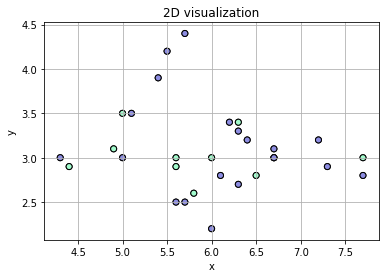

In [25]:
binary_visualize(Xtest4, Ytest4)

## Radial

In [26]:
X11 = Distribution.radial_binary(pts=300,
               mean=[0, 0],
               st=1,
               ed=2, seed=20)
X22 = Distribution.radial_binary(pts=300,
               mean=[0, 0],
               st=4,
               ed=5, seed=20)

Y11 = np.ones(X11.shape[0])
Y22 = np.zeros(X11.shape[0])

X5 = np.vstack((X11, X22))
y5 = np.hstack((Y11, Y22))

In [27]:
y5 = to_onehot(y5)

In [28]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=50, random_state=42)

In [29]:
y_train5.shape

(550, 2)

In [30]:
model5 = Sequential(verbose=1, vis_each_epoch=True)
model5.add(Dense(10, input_dim=2, seed=1))
model5.add(Activation('sigmoid'))
model5.add(Dense(2, seed=2))
model5.add(Activation('sigmoid'))
model5.add(Dense(2, seed=3))
# model5.add(Activation('sigmoid'))
sgd = StochasticGradientDescent(learning_rate=0.05)
model5.compile(optimizer=sgd, loss="mean_squared_error")


epoch: 1/4  acc: 77.18  loss: 0.256 


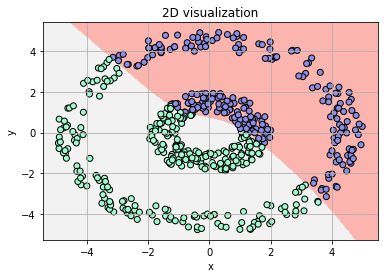

[██████████                              ] 25% 
epoch: 2/4  acc: 92.82  loss: 0.184 


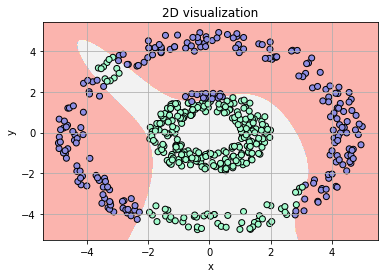

[████████████████████                    ] 50% 
epoch: 3/4  acc: 99.27  loss: 0.061 


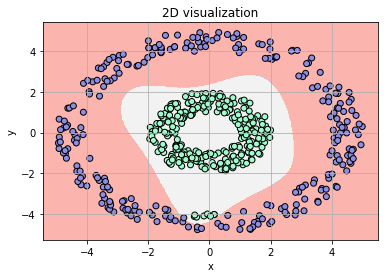

[██████████████████████████████          ] 75% 
epoch: 4/4  acc: 100.00  loss: 0.020 


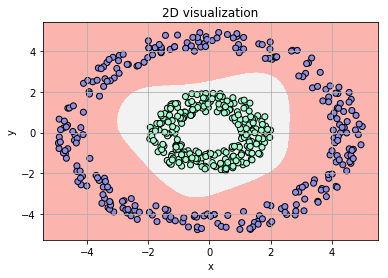

[████████████████████████████████████████] 100% CPU times: user 2.51 s, sys: 1.62 s, total: 4.13 s
Wall time: 2.17 s


In [31]:
%time model5.fit(X_train5, y_train5, batch_size=16, epochs=4)

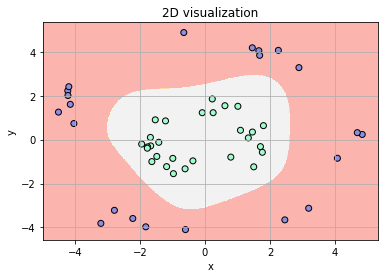

In [32]:
binary_visualize(X_test5, clf=model5, draw_contour=True)